### Ejercicios 00. Métodos Numéricos Básicos
Nombre: María Alejandra Lemus Nemocón

## Determinación del movimiento de un satélite artificial a partir de la ecuación de Kepler

Este trabajo tiene como objetivo determinar el movimiento de un satélite artificial utilizando la ecuación de Kepler. A partir de esta ecuación, se busca graficar la órbita del satélite y calcular la época en la que se encuentra, dada una posición radial. Para realizar estos cálculos, se emplearon las siguientes ecuaciones:

### Ecuación de Kepler
La ecuación de Kepler describe la relación entre la anomalía excéntrica $(E)$, el tiempo $(t)$ y la anomalía media $(l)$. Esta ecuación es crucial para determinar la posición del satélite en su órbita en función del tiempo.

$$
E - e \sin E = \sqrt{\frac{G M}{a^3}}\left(t - t_\rho\right) = l
$$

Donde:
- $E$ es la anomalía excéntrica,
- $e$ es la excentricidad de la órbita,
- $G$ es la constante gravitacional,
- $M$ es la masa del cuerpo central,
- $a$ es el semi-eje mayor de la órbita,
- $t_\rho$ es el tiempo de paso por el perigeo,
- $l$ es la anomalía media.

### Relación entre la anomalía verdadera y la anomalía excéntrica
Para obtener la anomalía verdadera $(f)$, que describe la posición angular del satélite en su órbita, se usa la relación entre la anomalía excéntrica $(E)$ y la anomalía verdadera $(f)$, dada por:

$$
\tan \left(\frac{E}{2}\right) = \sqrt{\frac{1 - e}{1 + e}} \tan \left(\frac{f}{2}\right)
$$

Donde:
- $f = \varphi - \omega$, siendo $(\omega)$ el argumento del pericentro.

### La órbita de un satélite artificial
La órbita de un satélite artificial se describe mediante una elipse, cuya forma y tamaño dependen de los parámetros orbitales. La distancia radial $(r)$ entre el satélite y el cuerpo central está dada por la siguiente ecuación:

$$
r(\varphi) = \frac{a(1 - e^2)}{1 + e \cos f}
$$

### Tercera Ley de Kepler: Periodo de una órbita
Finalmente, para determinar el periodo de la órbita $(T)$ de un satélite, se utiliza la tercera ley de Kepler, que establece que el cuadrado del periodo orbital es directamente proporcional al cubo del semi-eje mayor de la órbita:

$$
T = 2 \pi \sqrt{\frac{a^3}{G M}}
$$

### Implementación en el código
Con base en estas ecuaciones, el código que se presenta a continuación define tres funciones principales. La primera permite resolver la ecuación de Kepler mediante la búsqueda de raíces utilizando el método de Newton-Raphson, con el fin de determinar la anomalía excéntrica. Luego, mediante su relación con la anomalía verdadera, se determinan las coordenadas radiales $(r(t))$ y angulares $(\varphi(t))$. La segunda función permite graficar la órbita del satélite artificial, teniendo en cuenta el periodo obtenido mediante la tercera ley de Kepler. La tercera función, a partir de la órbita del satélite, utiliza interpolación polinómica de segundo grado para estimar la época en la que se encuentra el satélite a partir de una distancia radial dada.



In [5]:
import numpy as np
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt

# Método de Newton-Raphson para resolver la ecuación de Kepler
def solve_Eq_keppler_Newton_Raphson(t, t_p, a, e, n_iteraciones=1000):
    G_M_T = 398600.4405e9 * u.m**3 / u.s**2 

    t = Time(t, scale='utc')
    t_p = Time(t_p, scale='utc')
    
    delta_t = (t - t_p).to(u.s).value
    n = np.sqrt((G_M_T / a**3).decompose().value)
    l = n * delta_t
    l = l % (2 * np.pi)

    E = l
    # epsilon_maquina = 2.220446049250313e-16
    tolerancia = 1e-13

    for _ in range(n_iteraciones):
        g = E - e * np.sin(E) - l
        g_prima = 1 - e * np.cos(E)
        E_r = E - g / g_prima
        if abs(E_r - E) < tolerancia:
            return E_r, a
        E = E_r

    raise RuntimeError("No convergió el método de Newton-Raphson")   

# Obtener la anomalía verdadera desde la excéntrica usando tangente
def obtain_f_from_E(E, e):
    tan_f_2 = np.tan(E / 2) * np.sqrt((1 + e) / (1 - e))
    f = 2 * np.arctan(tan_f_2)
    if f < 0:
        f += 2 * np.pi
    return f

# Función principal que calcula φ(t) y r(t)
def position(t, t_p="2025-03-31 00:00:00", a=1.30262 * u.R_earth, e=0.16561, w=15, print_values=True, retornar=False):
    E, a = solve_Eq_keppler_Newton_Raphson(t, t_p, a, e)
    f = obtain_f_from_E(E, e)
    f_degree = np.degrees(f)
    
    # Calcular coordenada angular (phi = f - w)
    phi = f_degree + w
    # Calcular coordenada radial en kilómetros
    r = (a * (1 - e**2)) / (1 + e * np.cos(f))
    r = r.to(u.km)

    if print_values:
        print(f"La posición del satélite en la época {t} UTC es:")
        print(f"φ(t) = {phi:.8f} grados")
        print(f"r(t) = {r.value:.8f} km")
        print("Con los siguientes parámetros obtenidos de resolver la ecuación de Kepler:")
        print(f"Anomalía excéntrica E(t) = {E:.8f} rad")
        print(f"Anomalía verdadera f(t) = {f:.8f} rad")
    
    if retornar:
        return phi, r
    

# Graficar la orbita del satelite artificial
def orbit(t_p="2025-03-31 00:00:00", a=1.30262 * u.R_earth, e=0.16561, w=15, graficar=True, retornar=False):
    G_M_T = 398600.4405e9 * u.m**3 / u.s**2 

    T = 2 * np.pi * np.sqrt((a**3 / G_M_T).decompose().value)
    x_vals, y_vals = [], []

    t_p_time = Time(t_p, scale='utc')
    times = np.linspace(0, T, 10000)

    for delta_t in times:
        t = (t_p_time + delta_t * u.s).iso
        try:
            phi_degree, r = position(t, t_p, a, e, w, print_values=False, retornar=True)
            phi_rad = phi_degree * np.pi / 180
            x = r.value * np.cos(phi_rad)
            y = r.value * np.sin(phi_rad)
            x_vals.append(x)
            y_vals.append(y)
        except RuntimeError as err:
            print(f"No convergió en t = {t}: {err}")
            continue

    if retornar:
        return x_vals, y_vals

    if graficar:
        plt.figure(figsize=(7, 7))
        plt.plot(x_vals, y_vals, color ='#ffdea4', label="Órbita")
        plt.scatter(0, 0, color='blue', label='Tierra')
        plt.xlabel(r"$r \cdot \cos(\varphi)$")
        plt.ylabel(r"$r \cdot \sin(\varphi)$")
        plt.title(r"Órbita del satélite artificial")
        plt.grid(linestyle="--", linewidth=0.05)
        plt.legend()
        plt.show()

        
# Interpolar la posición radial a la orbita gráficada para obtener la posición angular
def interpolate_p2(r0, r_values, phi_rad_values):
    r0 = r0.to_value(u.km)
    #print('r0:', r0)
    r_values = r_values.to_value(u.km)

    # Calcular las diferencias de los radios con r0
    chi_2 = np.abs(r_values - r0)

    # Seleccionar los 6 puntos más cercanos a r0
    indices_minimos = np.argsort(chi_2)[:6]
    r_6_values = r_values[indices_minimos]
    phi_6_values = phi_rad_values[indices_minimos]

    # Ordenar los 6 valores por los ángulos (de menor a mayor)
    sorted_indices = np.argsort(phi_6_values)
    r_sorted = r_6_values[sorted_indices]
    phi_sorted = phi_6_values[sorted_indices]
    
    # Dividir los 6 valores en dos grupos según los ángulos
    mid_point = len(r_sorted) // 2  
    group_1_values = r_sorted[:mid_point], phi_sorted[:mid_point]  # Valores de r y phi para el primer grupo
    group_2_values = r_sorted[mid_point:], phi_sorted[mid_point:]  # Valores de r y phi para el segundo grupo

    # Asegurar que cada grupo tiene valores adecuados para la interpolación
    if len(group_1_values[0]) < 2 or len(group_2_values[0]) < 2:
        raise ValueError("Se necesitan al menos dos puntos en cada grupo para interpolar.")

    # Interpolación polinómica de segundo grado en radianes
    def pol_2(r0, r_interp, phi_unwrapped):
        return (((r0 - r_interp[1]) * (r0 - r_interp[2])) / ((r_interp[0] - r_interp[1]) * (r_interp[0] - r_interp[2]))) * phi_unwrapped[0] + \
               (((r0 - r_interp[0]) * (r0 - r_interp[2])) / ((r_interp[1] - r_interp[0]) * (r_interp[1] - r_interp[2]))) * phi_unwrapped[1] + \
               (((r0 - r_interp[0]) * (r0 - r_interp[1])) / ((r_interp[2] - r_interp[0]) * (r_interp[2] - r_interp[1]))) * phi_unwrapped[2]

    # Realizar la interpolación para ambos grupos
    phi_interp_1 = pol_2(r0, group_1_values[0], group_1_values[1])
    phi_interp_2 = pol_2(r0, group_2_values[0], group_2_values[1])
    
    # Convertir el ángulo final a grados
    phi0_deg_1 = phi_interp_1 * 180 / np.pi
    phi0_deg_2 = phi_interp_2 * 180 / np.pi

    return phi0_deg_1, phi0_deg_2

# Obtener la anomalía excéntrica desde la verdadera usando tangente
def obtain_E_from_f(f, e):
    tan_E_2 = np.tan(f / 2) * np.sqrt((1 - e) / (1 + e))
    E = 2 * np.arctan(tan_E_2) * u.rad
    if E < 0 * u.rad:
        E += 2 * np.pi * u.rad
    return E

# Obtener la época a partir de la anomalía excéntrica
def obtain_t_from_E(E, e, a, t_p):
    G_M_T = 398600.4405e9 * u.m**3 / u.s**2 

    n = np.sqrt((G_M_T / a**3).decompose().value)
    E_val = E.to_value(u.rad)
    delta_t_val = (E_val - e * np.sin(E_val)) / n
    delta_t = delta_t_val * u.s

    t_p = Time(t_p, scale='utc')
    t = t_p + delta_t
    
    # Convertir el tiempo a un objeto datetime para acceder a horas, minutos y segundos
    t_datetime = t.datetime

    # Obtener la fecha en formato YYYY-MM-DD
    date_part = t_datetime.strftime('%Y-%m-%d')

    # Obtener las horas, minutos y segundos con decimales
    hours = t_datetime.hour
    minutes = t_datetime.minute
    seconds = t_datetime.second
    fractional_seconds = t_datetime.microsecond / 1e6  # Convertir microsegundos a fracción de segundo

    # Reformatear el tiempo con los segundos con decimales, asegurando que siempre tenga tres decimales
    formatted_time = f"{date_part} {hours:02d}:{minutes:02d}:{seconds + fractional_seconds:06.3f}"
    
    return formatted_time

# Función principal que calcula la época en la que se encuentra el satelite dada una posición radial
def date(r0, t_p="2025-03-31 00:00:00", a=1.30262 * u.R_earth, e=0.16561, w=15):
    x_vals, y_vals = orbit(t_p=t_p, a=a, e=e, w=w, graficar=False, retornar=True)

    r_values = []
    phi_rad_values = []

    for x, y in zip(x_vals, y_vals):
        r = np.sqrt(x**2 + y**2)
        phi_rad = np.arctan2(y, x)
        r_values.append(r)
        phi_rad_values.append(phi_rad)

    r_values = np.array(r_values) * u.km
    phi_rad_values = np.array(phi_rad_values)

    r0_val = r0.to(u.km).value if isinstance(r0, u.Quantity) else r0
    r_min = np.min(r_values).to_value(u.km)
    r_max = np.max(r_values).to_value(u.km)

    if not (r_min <= r0_val <= r_max):
        raise ValueError(f"Radio no válido: r₀ = {r0_val:.2f} km está fuera del rango [{r_min:.2f}, {r_max:.2f}] km. Revise el valor.")

    phi0_1, phi0_2 = interpolate_p2(r0, r_values, phi_rad_values)

    # phi0_1
    f_degree_1 = phi0_1 - w
    f_1 = f_degree_1 * np.pi / 180
    E_1 = obtain_E_from_f(f_1, e)
    t_1 = obtain_t_from_E(E_1, e, a, t_p)

    # phi0_2
    f_degree_2 = phi0_2 - w
    f_2 = f_degree_2 * np.pi / 180
    E_2 = obtain_E_from_f(f_2, e)
    t_2 = obtain_t_from_E(E_2, e, a, t_p)
    
    # Determinar el formato de la distancia
    r0_rounded = np.round(r0_val, 3)
    if r0.unit == u.R_earth:
        r0_str = f"{r0.value} R⊕"

    else:
        r0_str = r0
    
    if t_1 < t_2:
        print(f"La primera época en la que el satélite se encuentra en la posición radial r0: {r0_str} ({r0_rounded} km) es {t_1} UTC")
        return t_1
    else:
        print(f"La primera época en la que el satélite se encuentra en la posición radial r0: {r0_str} ({r0_rounded} km) es {t_2} UTC")
        return t_2
                 

In [6]:
t = "2025-04-01 00:00:00"  # UTC
position(t)

La posición del satélite en la época 2025-04-01 00:00:00 UTC es:
φ(t) = 185.59671061 grados
r(t) = 9658.40915051 km
Con los siguientes parámetros obtenidos de resolver la ecuación de Kepler:
Anomalía excéntrica E(t) = 2.94778842 rad
Anomalía verdadera f(t) = 2.97747429 rad


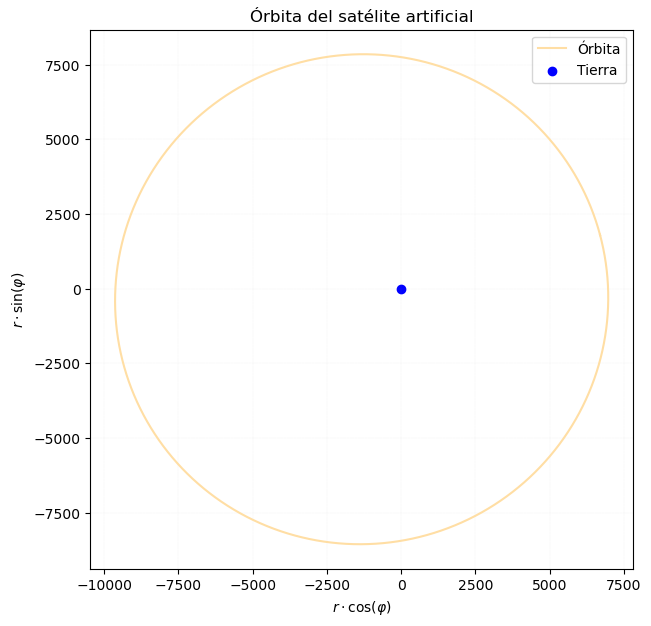

In [7]:
orbit()

In [8]:
t= date(1.5 * u.R_earth)

La primera época en la que el satélite se encuentra en la posición radial r0: 1.5 R⊕ (9567.15 km) es 2025-03-31 00:53:09.855 UTC
